In [19]:
# File handling and sorting
from glob import glob
import os
import datetime

# Math and plotting
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.ticker as tck
from matplotlib import pyplot as plt
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit


# http://emilygraceripka.com/blog/16
# Modified to include a vertical offset
def _1lorentzian(x, amp1, cen1, wid1, yoff):
    return (amp1*wid1**2/((x-cen1)**2+wid1**2)) + yoff

def _2lorentzian(x, amp1, cen1, wid1, amp2, cen2, wid2, yoff):
    return (amp1*wid1**2/((x-cen1)**2+wid1**2)) +\
            (amp2*wid2**2/((x-cen2)**2+wid2**2)) +\
            yoff

## User Tweaks

Select desired plot style for personal taste, but return to default white style for exporting

In [20]:
# plt.style.use('dark_background')
# plt.style.use('seaborn-white')
matplotlib.rcParams.update(matplotlib.rcParamsDefault) # Reset to default; use for exported figures
# plt.style.use('science')
# plt.style.use('notebook')

## Quick Plot

Use this for a quick and dirty plot of colleague's ODMR data.

> In his original Dropbox link, all of the data from the relevant runs was copied into
> a single spreadsheet as extra columns alongside original data. This mixed together the
> raw data and analysis into a single `.xls` spreadsheet, which was then exported to
> `.csv` for more compatible storage in Dropbox. The exporting eliminated the
> equations built into the spreadsheet, but the relevant data to plot is still accessible
> in the right-most 4 columns in the first acquisition of the similarly-named .csv files.

#### Path to analysis file (same as first file in similarly-named set of files)

In [33]:
# Look at folder that has all ODMR files; use those that have 50 ns delay
# files = glob('path/to/ODMR-directory/words*to*match')
files = glob('data/ODMR*50ns*.csv')
# Sort by creation time and select the oldest file
file = sorted(files, key = os.path.getctime)[-1]
file  # ODMR_500KBurst_350uW_50nsdelay.csv

'data/ODMR_500KBurst_350uW_50nsdelay.csv'

The file has 9 sets of 4 columns, separated by a few empty columns. The first set of
4 columns is the first ODMR acquisition:

| Microwave frequency (MHz)| Reference| Signal| Contrast = (sig - ref)/ref|
|--------------------------|----------|-------|---------------------------|
| 3200                     |  9614    | 9561  | 0.005512794               |

The second set of 4 columns is the ODMR acquisition from `same-filename---2.csv`.
There are 7 such files with exactly the same acquisition parameters, each corresponding
to intensity (APD counts) of the filterd PL signal for 500k microwave pulses. There is an
additional acquisition acquired with 1M microwave pulses with a modified filename to
represent the higher number of pulses but othewise collected with the same acquisition
settings. Because all of these files have identical acquisition parameters and were
measured sequentially, we can effectively integrate all counts from all files. This gives
us \[(7 x 500k) + 1M = 4.5M\] total microwave pulses over which we can integrate.
This is what the last set of 4 columns represents.

In [34]:
df = pd.read_csv(file, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,3200.0,9614.0,9561.0,0.005513,NaN,NaN,NaN,3200.0,18114.0,17812.0,...,-0.017121,NaN,NaN,Final Integrated Result with 4.5 million integ...,NaN,NaN,3200.0,74830.0,74804.0,0.000347
1,3205.0,8740.0,8638.0,0.011670,NaN,NaN,NaN,3205.0,20782.0,20646.0,...,-0.015015,NaN,NaN,NaN,NaN,NaN,3205.0,245713.0,245596.0,0.000476
2,3210.0,10046.0,10008.0,0.003783,NaN,NaN,NaN,3210.0,20185.0,20155.0,...,-0.026732,NaN,NaN,NaN,NaN,NaN,3210.0,80953.0,81211.0,-0.003187
3,3215.0,9277.0,9350.0,-0.007869,NaN,NaN,NaN,3215.0,20013.0,20178.0,...,-0.010855,NaN,NaN,NaN,NaN,NaN,3215.0,82979.0,83879.0,-0.010846
4,3220.0,10898.0,10945.0,-0.004313,NaN,NaN,NaN,3220.0,20018.0,20074.0,...,-0.001742,NaN,NaN,NaN,NaN,NaN,3220.0,88323.0,88683.0,-0.004076


We don't need all 58 columns. Let's reimport only the last 4 columns and clean up empty rows that contain NaN.

In [35]:
df = pd.read_csv(file, usecols=[54,55,56,57], header=None)
df.dropna(inplace=True)  # Remove empty rows, present from comments in other columns
df.columns = ['Frequency', 'Reference', 'Signal', 'Contrast']

# Colleague says his calculated contrast should be negative, but it is positive in this
# dataset. It is unclear if the Reference and Signal columns are identified correctly,
# but let's assume he labeled them correctly and simply mixed up the computed order of
# (sig - ref), which we can correct with an explicit sign change.
df['Contrast'] = -1 * df['Contrast']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103 entries, 0 to 102
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Frequency  103 non-null    float64
 1   Reference  103 non-null    float64
 2   Signal     103 non-null    float64
 3   Contrast   103 non-null    float64
dtypes: float64(4)
memory usage: 4.0 KB


We'll also want to fit this ODMR data to two Lorentzian peaks using `scipy.optimize.curve_fit`.
The curve_fit module is explicitly imported at the beginning of this notebook, and two generic
Lorentzian equations are defined above to be passed into the curve_fit function below.

In [32]:
# Define x and y valaues to be used in Lorentzian fits
x_array = df['Frequency'].values
y_array = df['Contrast'].values

# Make initial guesses for fit; will be updated below
amp1, cen1, wid1 = [10,3400,5]
amp2, cen2, wid2 = [10,3500,5]
yoff = 0.01

# Optimize curve fit and store parameters
popt_2lorentz, pcov_2lorentz = curve_fit(_2lorentzian, x_array, y_array, p0=[amp1, cen1, wid1, amp2, cen2, wid2, yoff])
perr_2lorentz = np.sqrt(np.diag(pcov_2lorentz))
pars_1 = popt_2lorentz[0:3]  # amp1, cen1, wid1
pars_2 = popt_2lorentz[3:6]  # amp2, cen2, wid2
pars_3 = popt_2lorentz[-1:]  # yoffset (need to have [-1:] instead of [-1], else error next line)
lorentz_peak_1 = _1lorentzian(x_array, *pars_1, *pars_3)
lorentz_peak_2 = _1lorentzian(x_array, *pars_2, *pars_3)

Plot the data along with its accompanying fit. Display the fit parameters below in case they are needed elsewhere.

ODMR_500KBurst_350uW_50nsdelay.csv 



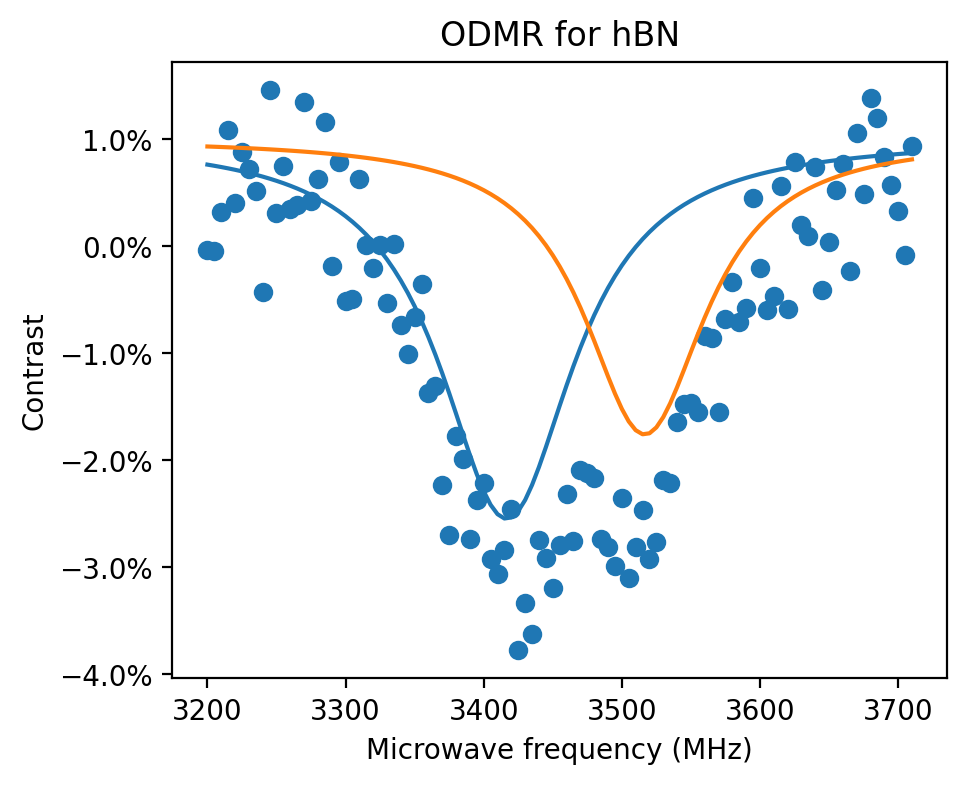

----- Peak 1 ---------
Amplitude:  -0.035567
Center:     3416.5
Width:      59.17
V. Offset:  0.01011
---------------------

----- Peak 2 ---------
Amplitude:  -0.027695
Center:     3516.5
Width:      53.78
V. Offset:  0.01011
---------------------


In [38]:
# Display results
fig = plt.figure(1, (5,4))
ax = fig.add_subplot(1,1,1)
ax.scatter(x_array, y_array)  # Contrast values per frequency
ax.plot(x_array, _2lorentzian(x_array, *popt_2lorentz), c="C7", linewidth=3)  # Double Lorentz fit
# ax.plot(x_array, lorentz_peak_1)  # Explicit peak 1
# ax.plot(x_array, lorentz_peak_2)  # Explicit peak 2
plt.title('ODMR for hBN')
ax.set_xlabel('Microwave frequency (MHz)')
ax.set_ylabel('Contrast')
ax.yaxis.set_major_formatter(tck.PercentFormatter(1.0))


print(os.path.basename(file), '\n')
plt.show()
print('----- Peak 1 ---------')
print('Amplitude: ', round(pars_1[0], 6))
print('Center:    ', round(pars_1[1], 1))
print('Width:     ', round(pars_1[2], 2))
print('V. Offset: ', round(pars_3[0], 6))
print('---------------------\n')

print('----- Peak 2 ---------')
print('Amplitude: ', round(pars_2[0], 6))
print('Center:    ', round(pars_2[1], 1))
print('Width:     ', round(pars_2[2], 2))
print('V. Offset: ', round(pars_3[0], 6))
print('---------------------')

---
# Refined Analysis

The pipeline above works for the file that our colleague provided, but the processing pipeline
can be generalized and extended in the event more raw ODMR data is provided.

### Guidelines

The user is expected to provide a list of files of ODMR spectra collected at the same
location and with identical power settings. The filenames can differ in number of microwave
bursts, but currently the number of integrations is not tracked in the dataframe. The ODMR
data is concatenated for all files in this list, so extending the integration is as simple
as adding another file to the list.

#### Data requirements

- Files in list have identical structure \[Frequency, Ref, Sig\]
- Frequency values in each file have an overlapping subset
- Frequency values are between 0 and 65e3 (uint16)
- APD counts from all accumulated runs do not total more than 4.2e9 (uint32) in either channel

#### Usage:

- Adjust the filename list to point to the directory where your ODMR files are located
- If analysis is needed on only one file, pass in a list of one element.
- Select appropriate filtering in `glob` to pick out a subset of files if desired
- Adjust threshold and distance parameters for cleaning via scipy.signal.find_peaks
- Run All Cells
    - Inspect cleaning results, adjust threshold as necessary
- Grab figures as necessary for publication
    - Adjust graph style with rcParams instead of in plot


##### Scripting Support

> To be included

Goal: call this function from the command line:

```sh
% python ODMR_Analysis.py -f files.csv -o output.png
```

where `output.png` is the result of the total ODMR contrast as computed from all input files.
`files.csv` can be one file or multiple files and may come from standard input so that
it can be included in a pipeline

```sh
% ls files-to-match | python ODMR_Analysis.py -o /path/to/output.png
```

Bonus: be able to adjust `threshold` and `distance` from command line.


In [7]:
def read_ODMR_csv_to_df(file):
    """Return dataframe of first 3 columns in csv file.
    
    Expected .csv contents: Frequency, Reference, Signal.
    Converts Frequency to the index of the dataframe.
    """
    colnames = ['Frequency', 'Reference', 'Signal']
    dtypes = {'Frequency': np.float32, 'Reference': np.int64, 'Signal': np.int64}
    df = pd.read_csv(file,
                     usecols=[0,1,2],
                     names=colnames,
                     header=None,
                    )
    df.dropna(inplace=True)
    for c in df.columns:
        df[c] = df[c].astype(dtypes[c])
    df = df.set_index('Frequency')
    return df

def find_peaks_and_valleys(array, threshold=30, distance=1):
    """Return index of peaks and valleys in an array.
    
    Suggested usage:
    >>> highlights = find_peak_and_valleys(y)
    >>> plt.plot(x,y)  # View normal graph
    >>> plt.scatter(x[highlights], y[highlights])  # Highlight sharp points
    """
    peaks, props = find_peaks(array,
                              distance=distance,
                              height=(min(array), max(array)),
                              threshold=threshold,
                             )
    inv_array = array * (-1)
    valleys, props = find_peaks(inv_array,
                                distance=distance,
                                height=(min(inv_array), max(inv_array)),
                                threshold=threshold,
                               )
    return np.concatenate((peaks, valleys))

def peaks_and_valleys_in_plot(x_array, y_array, threshold=30, distance=1):
    """Return x[idx], y[idx] where idx are peak and valley indices in y.
    
    Suggested useage:
    >>> plt.plot(x,y)  # View normal graph
    >>> plt.scatter(*peaks_and_valleys_in_plot(x,y)) ## Highlight points
    """
    idx = find_peaks_and_valleys(y_array, threshold=threshold, distance=distance)
    return np.asarray(x_array[idx]), np.asarray(y_array[idx])
    
def peaks_in_plot(x_array, y_array, threshold=30, distance=1):
    """Return x[pk_idx], y[pk_idx] where pk_idx values are found in y.
    
    Converts result of find_peaks index for y to be in same units as x
    when trying to plot y(x) relationship.
    
    Sugested usage:
    >>> plt.plot(x,y) # View normal graph
    >>> plt.scatter(*peaks_in_plot(x, y)) # Highlight peaks
    """
    pk_idx, props = find_peaks(y_array,
                               distance=distance,
                               height=(min(y_array), max(y_array)),
                               threshold=threshold,
                              )
    return np.asarray(x_array[pk_idx]), np.asarray(y_array[pk_idx])

def peaks_and_values(x_array, threshold=30, distance=1):
    """Return [index], [peak_value] arrays that correspond to peaks in input array.
    
    Peaks are defined by a maximum value according to input threshold. The higher
    the threshold, the larger the peak needs to be in order to register as a peak.
    
    Valleys can be found by passing in the negative version of an array and inverting
    the output of peak_value.
    """
    pk_idx, props = find_peaks(x_array,
                               distance=distance,
                               height=(min(x_array), max(x_array)),
                               threshold=threshold,
                              )
    return pk_idx, props['peak_heights']
    
def remove_spikes(array, distance=1, threshold=30):
    """Remove large spikes in data and replace them with the average of its neighbors."""
    array = array.copy()
    peaks, props = find_peaks(array, distance=distance, threshold=threshold)
    for i in peaks:
        # I experimented with different settings, but found a narrow replacement worked
        # better for peaks near the beginning or end of the dataset. Keep threshold high
        # to prevent overzealous removal of noise.
        array[i-1:i+1] = np.mean(np.concatenate([array[i-3:i-5],array[i+4:i+6]])) # This part can be altered as needed.
    return array

def scale_array(array, factor):
    """Multiply all values in array by a common factor."""
    new_array = array.copy()
    for i, x in enumerate(array):
        new_array[i] = x * factor
    return new_array

In [49]:
# Gather all raw ODMR files and set directories
files = sorted(glob('data/ODMR*50ns*.csv'))
dat_dir = os.path.dirname(files[0])  # Identify ODMR data folder
# The following path might need to be changed if this notebook is
# is converted to a script, housed in a different location
fig_dir = 'figs' 

print('Data directory:  ', dat_dir)
print('Figure directory:', fig_dir)

Data directory:   data
Figure directory: figs


['data/ODMR_1MBurst_350uW_50nsdelay.csv',
 'data/ODMR_500KBurst_350uW_50nsdelay.csv',
 'data/ODMR_500kBurst_350uW_50nsdelay---2.csv',
 'data/ODMR_500kBurst_350uW_50nsdelay---3.csv',
 'data/ODMR_500kBurst_350uW_50nsdelay---4.csv',
 'data/ODMR_500kBurst_350uW_50nsdelay---5.csv',
 'data/ODMR_500kBurst_350uW_50nsdelay---6.csv',
 'data/ODMR_500kBurst_350uW_50nsdelay---7.csv']

### Inspect Raw Data

Look at the Reference and Signal counts in each file to see if any unusual spikes occur
in either case. We don't want these to skew our contrast. The below code detects spikes
in the data using `scipy.signal.find_peaks` and the user-defined parameters `threshold`
and `distance`.

Adjust the threshold and distance parameters below until you are satisfied with the
detection of *unusual* spikes. The Reference and Signal counts fluctuate a decent amount
even on a well-behaved run, so keep the threshold high so that you don't inadvertently
cut out meaningful signal.

Ensure that the peaks are selected for both Reference **and** Signal at the same location.

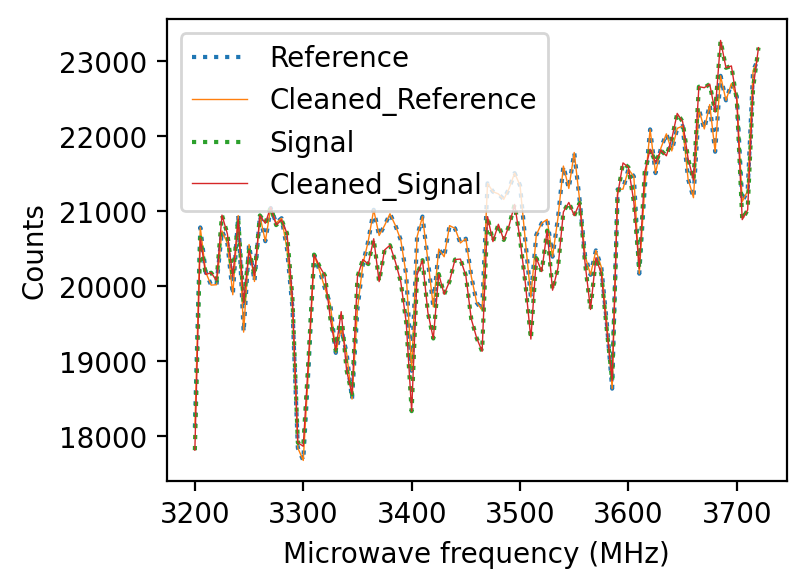

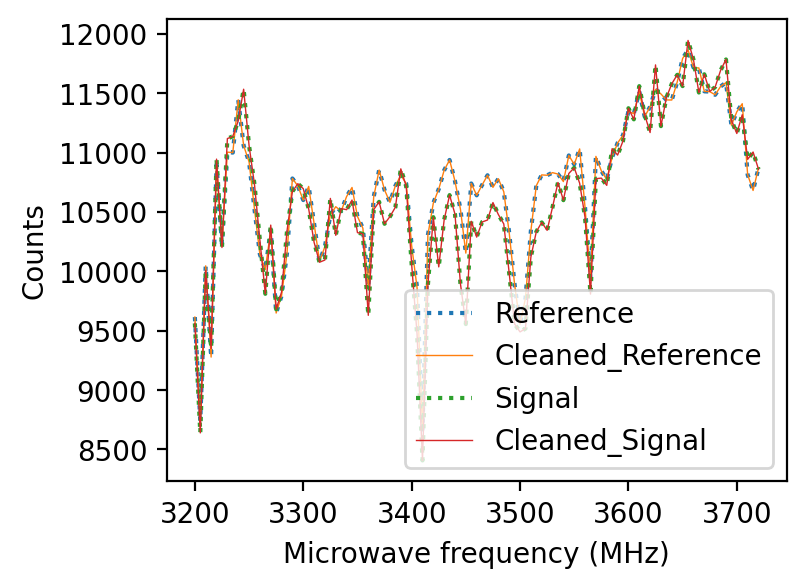

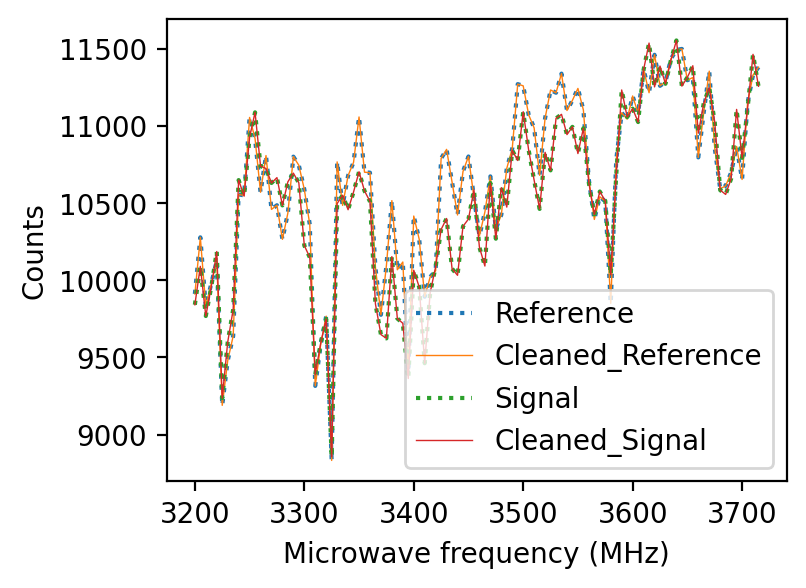

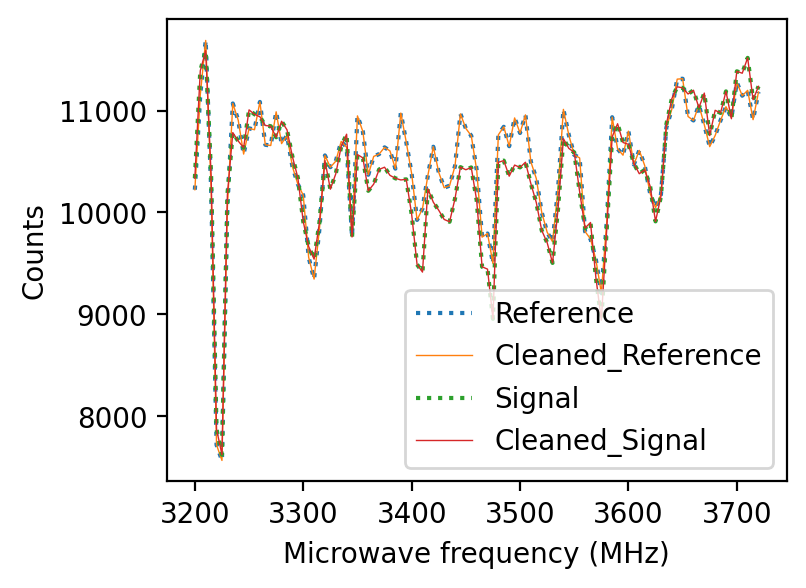

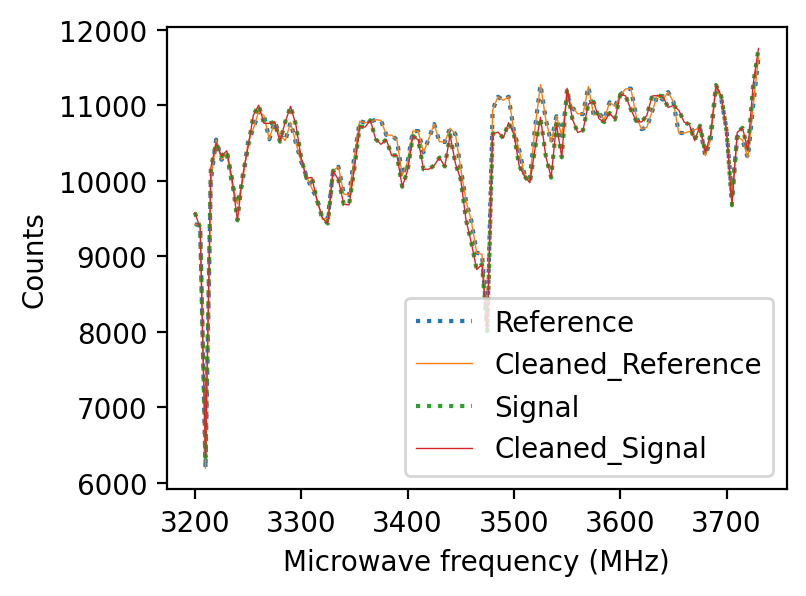

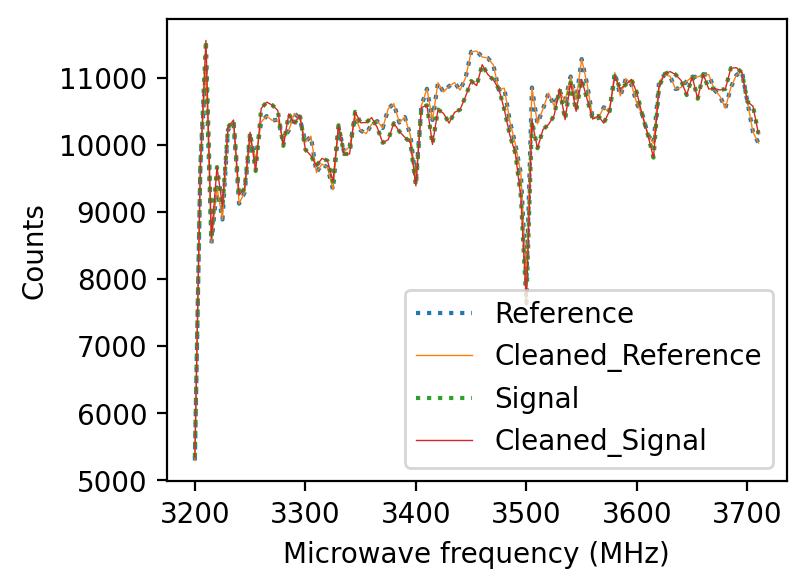

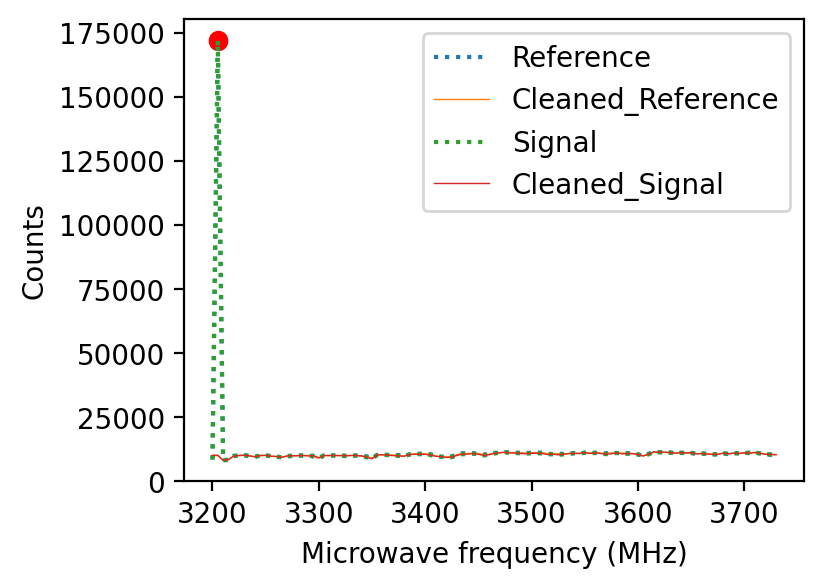

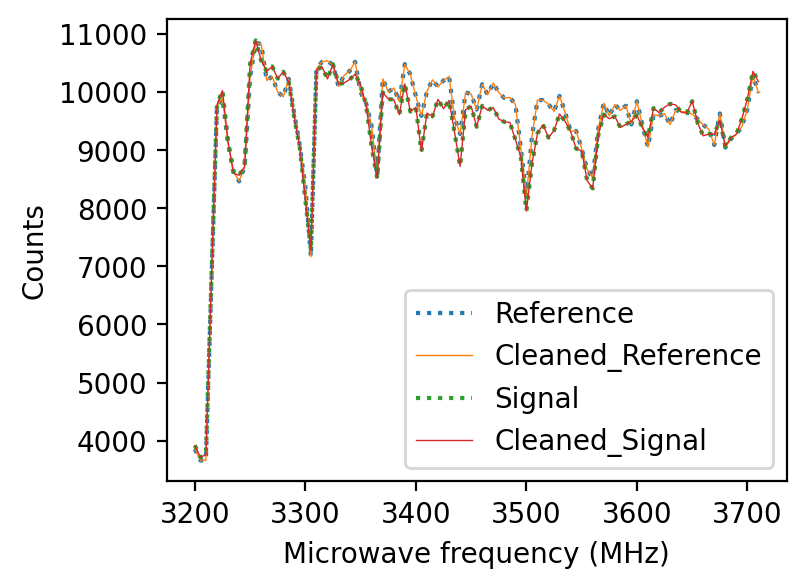

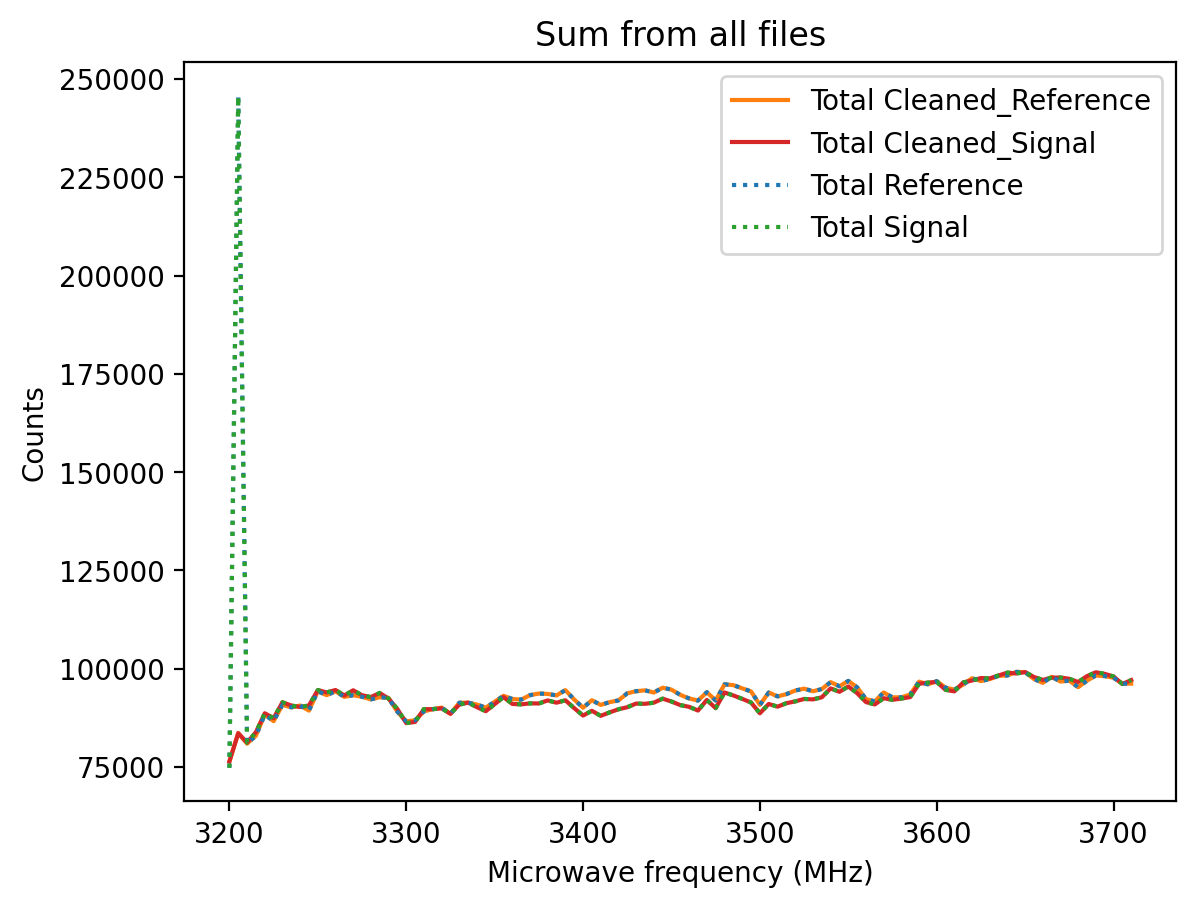

In [50]:
# User tweaks --
threshold = 2000  # Keep large, filter out only BIG spikes
distance = 1
SCALE_FACTOR = 1e-3  # Convert x-axis on final ODMR graph (e.g. from MHz to GHz)
print_title = False  # Whether to include figure title in output (F for publication, T for slidedeck)
# --------------

# Generate template dataframe for frequencies, empty everything else
total_df = pd.DataFrame()

for file in files:
    filename = os.path.basename(file)  # Strip off directory name
    df = read_ODMR_csv_to_df(file)
    
    fig = plt.figure(1, (4,3))
    ax = fig.add_subplot(1,1,1)
    # Plot original counts, detected peaks, corrected counts
    for col in df.loc[:,['Reference', 'Signal']]:
        # Original data
        ax.plot(df[col], linestyle='dotted', label=col)
        # Detected peaks
        pk_idx, pk_vals = peaks_and_values(df[col], threshold=threshold, distance=distance)
        ax.scatter(df.index.values[pk_idx], pk_vals, color='red')
        # Cleaned data
        new_column = 'Cleaned_' + col
        df[new_column] = remove_spikes(df[col].values,
                                       threshold=threshold,
                                       distance=distance,
                                      )
        ax.plot(df[new_column], linewidth=0.5, label=new_column)
#         ax.legend()
    # Plot formatting
#     plt.title(filename)
    ax.set_xlabel('Microwave frequency (MHz)')
    ax.set_ylabel('Counts')
    plt.legend()
    plt.show()
    
    # While we are iterating, add similar column names together into new df
    total_df = pd.concat([total_df,df], axis=1)  # Copy columns to right
    total_df.dropna(inplace=True)  # Pick out only rows that overlap entirely
    total_df = total_df.groupby(level=0, axis=1).sum()  # Sum all values with same column name
    
# Format total_df to match plot styles above;
# necessary b/c plot and scatter use different color cycles
colors = {"Reference": "C0", "Signal": "C2", "Cleaned_Reference": "C1", "Cleaned_Signal": "C3"}
linestyles = {"Reference": "dotted", "Signal": "dotted", "Cleaned_Reference": "solid", "Cleaned_Signal": "solid"}

for col in total_df.columns:
    total_df[col] = total_df[col].astype(np.float32)  # Helps keep filesize small
    plt.plot(total_df[col], label=f'Total {col}', c=colors[col], linestyle=linestyles[col])
plt.title('Sum from all files')
plt.xlabel('Microwave frequency (MHz)')
plt.ylabel('Counts')
plt.legend()
plt.show()

### Generate ODMR contrast from cleaned, aggregate data

File saved to figs/ODMR_contrast.png
Integrations:  4.50e+06


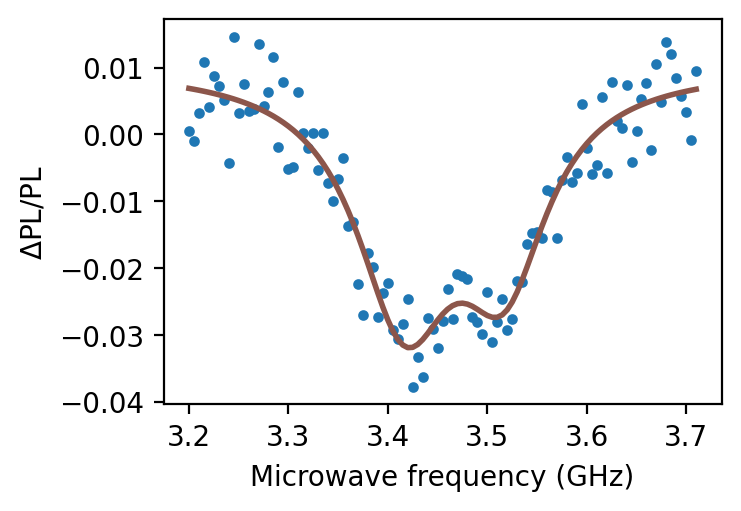

        Amplitude    Center     Width
Peak 1  -0.035567  3.416506 -0.059199
Peak 2  -0.027707  3.516549  0.053874


In [51]:
# Generate contrast columns for original and cleaned data
# Contrast = (sig - ref) / ref
total_df['Cleaned_Contrast'] = (total_df['Cleaned_Signal'] - total_df['Cleaned_Reference']) / total_df['Cleaned_Reference']
total_df['Contrast'] = (total_df['Signal'] - total_df['Reference']) / total_df['Reference']

# Generate fits
# Define x and y valaues to be used in Lorentzian fits
x_array = total_df.index.values
y_array = total_df['Cleaned_Contrast'].values

# Make initial guesses for fit; will be updated below
pars_1 = [1,3400,1]  # amp, cen, wid
pars_2 = [1,3500,1]  # amp, cen, wid
yoff = 0.01  # same for both peaks

# Rescale Frequency and fitting data
x_array = scale_array(x_array, SCALE_FACTOR)
pars_1 = scale_array(pars_1, SCALE_FACTOR)
pars_2 = scale_array(pars_2, SCALE_FACTOR)
# TODO: Find a way to nest this in a loop
# Tried, but does not work:
#   [scale_array(each, SCALE_FACTOR) for each in (x_array, pars_1, pars_2)]

# Optimize curve fit and store parameters
popt_2lorentz, pcov_2lorentz = curve_fit(_2lorentzian, x_array, y_array, p0=[*pars_1, *pars_2, yoff])
perr_2lorentz = np.sqrt(np.diag(pcov_2lorentz))
pars_1 = popt_2lorentz[0:3]  # amp1, cen1, wid1
pars_2 = popt_2lorentz[3:6]  # amp2, cen2, wid2
pars_3 = popt_2lorentz[-1:]  # yoffset
lorentz_peak_1 = _1lorentzian(x_array, *pars_1, *pars_3)
lorentz_peak_2 = _1lorentzian(x_array, *pars_2, *pars_3)

# Display results
# fig, ax = plt.subplots()
# fig, ax = plt.subplots(figsize=(2.5,2.5)) # Original
# fig, ax = plt.subplots(figsize=(2.5,1.33)) # TOC subset
fig, ax = plt.subplots(figsize=(3.6,2.5)) # wide
fig.patch.set_alpha(0)
# ax = fig.add_subplot(1,1,1)

ax.scatter(x_array, y_array, s=8)  # Contrast values per frequency
ax.plot(x_array, _2lorentzian(x_array, *popt_2lorentz), c="C5", linewidth=2)  # Double Lorentz fit
# ax.scatter(x_array, y_array, s=4)  # Contrast values per frequency
# ax.plot(x_array, _2lorentzian(x_array, *popt_2lorentz), c="C5")  # Double Lorentz fit
# ax.plot(x_array, lorentz_peak_1)  # Explicit peak 1
# ax.plot(x_array, lorentz_peak_2)  # Explicit peak 2
if print_title:
    plt.title('ODMR for hBN')
ax.set_xlabel('Microwave frequency (GHz)') # TODO: Update label based on SCALE_FACTOR
# ax.set_ylim(None,2.5e-2)
ax.set_ylabel('$\Delta \mathrm{PL}/ \mathrm{PL}$')
# ax.ticklabel_format(style='sci', scilimits=(-1,0))
# ax.yaxis.tick_right()
# ax.yaxis.set_major_formatter(tck.PercentFormatter(1.0))
# plt.legend()

fig_name = 'ODMR_contrast'
fig_ext = 'png'
fig_path = ''.join((fig_dir, '/', fig_name, '.', fig_ext))
fig.savefig(fig_path, format=fig_ext, dpi=300, bbox_inches='tight')
print(f'File saved to {fig_path}')

integrations = 4.5e6  # TODO: Find out a way to determine this from files
print('Integrations: ', '{:.2e}'.format(integrations))
plt.show()


header = ['Amplitude', 'Center', 'Width']
data = [pars_1, pars_2]
indices=['Peak 1', 'Peak 2']
print(pd.DataFrame(data, indices, header))

# TODO Items

1. [ ] Let user specify whether title should appear in figure.
    - Titles are useful when presenting figures in meetings.
    - Titles are sometimes superfluous in compound figures, where the graph will be identified in the caption.
1. [ ] Specify a global scaling factor to display data.
    - Data should remain in SI units (i.e. Frequency in Hz, not GHz).
    - Graph axes labels should update with scale.
        - Ideally, this should only affect plot, but not underlying dataframe.
        - Fits and analysis also need to scale with this factor.
        - For now, only needs to apply to x-axis values (Frequency).
1. [ ] Add quality checks to prevent user from inputing wrong data files (wrong fname_str)
    - [ ] Raise error if data files don't have 3 columns
    - [ ] Raise error if frequency counts are negative
    - Aim to raise errors for input that will "work" but won't give desired results
        - Program already fails loudly on incompatible dtypes; make it fail if compatible but nonsensical
1. [ ] Make unit tests
    - [ ] Test whether SCALE_FACTOR can be 1e-9, ... , 1e9
    - [ ] Test that neg freq values and neg counts don't crash
        - User can see from plot that data doesn't make sense
1. [ ] Refactor notebook.
    - [ ] Move all definitions into a logically-grouped module.
    - [ ] Group together user-modifiable parameters and let these be inputs
        - [ ] Make these optional inputs, and specify sensible defaults
        - [ ] Let graphs be controlled by rcParams instead of hard coding figsize, line, color, etc
            - User can call own style file to control all plots at once
            - Figure out how to specify relative large/small figures w/in rcParam settings
    - [ ] Main function should be to generate ODMR plot from input files.
        - [ ] Also make function to inspect all data files (shows before/after cleaning)
    - [ ] Make the analysis scriptable from command line.
        - Example usage:
        ```sh
        % python ODMR_Analysis.py -f data_file1.csv data_file2.csv -o path/to/output.png
        ```
1. [ ] Call the contents of this notebook from a single notebook responsible for generating all figures in paper.
    ```python
    # Sharable_final_notebook.ipynb
    from ODMR_Analysis import plot_ODMR
    from other_module import other_plot
    
    ODMR_data_params = {'dat_dir': dat_path,
                        'fig_dir': fig_path,
                        'files_to_select': fname_str,
                        'print_title': False,
                        # other user-tweaks
                       }
    plot_ODMR(*ODMR_data_params)  # Display results in notebook, update fig in fig_dir
    
    other_plot(*other_params) # Display other results in same notebook
    ```